# Deceptive / truthful comments classifier

In [2]:
import pandas as pd
import numpy as np
import pprint
from time import time
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Style and size of graph
sns.set_style("darkgrid")

### Importing the dataset

In [3]:
df = pd.read_csv('deceptive-opinion.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


### Text parser function
Clean punctuation, split the text to invividual words, stemm word with english stemmer, remove specific stopwords if any.

In [4]:
from nltk.stem.snowball import SnowballStemmer
import string

def parseOutText(all_text):
    ### clean punctuation
    text_string = all_text.translate(str.maketrans("", "", string.punctuation))   
    ### split the text string into individual words, stem each word,
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for  word in text_string.split()]
    words = " ".join(stemmed)    
    ### use str.replace() to remove any instances of the stopwords
    # to be completed with word to be removed
    stopwords = []
    for word in stopwords:            
        words = words.replace(word, "")  
    return words

### List of words (text) and labels

In [5]:
word_data = []
deceptive_data = []

for element in df['text']:
    word_data.append(parseOutText(element))

for val in df['deceptive']:
    if val == 'truthful':
        deceptive_data.append(0)
    elif val == 'deceptive':
        deceptive_data.append(1)
    else:
        deceptive_data.append(-1)
        print('unexpected value:',val)

### Vectorize function with Tfid
Generating the train/test labels/features.

In [6]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(word_data, deceptive_data, test_size=0.3, random_state=42)

# Tfid vectorizer of data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words = 'english')
features_train = vectorizer.fit_transform(features_train)
features_test  = vectorizer.transform(features_test).toarray()
words = vectorizer.get_feature_names()
features_train = features_train.toarray()

### Check for patterns :  t-distributed Stochastic Neighbour Embedding

In [17]:
from sklearn.manifold import TSNE

X = features_train
y = labels_train

tsne = TSNE(
    n_components=2,
    init='pca',
    random_state=0,
    perplexity=50,
    early_exaggeration=25,
    n_iter=400
)

Tx = tsne.fit_transform(X)

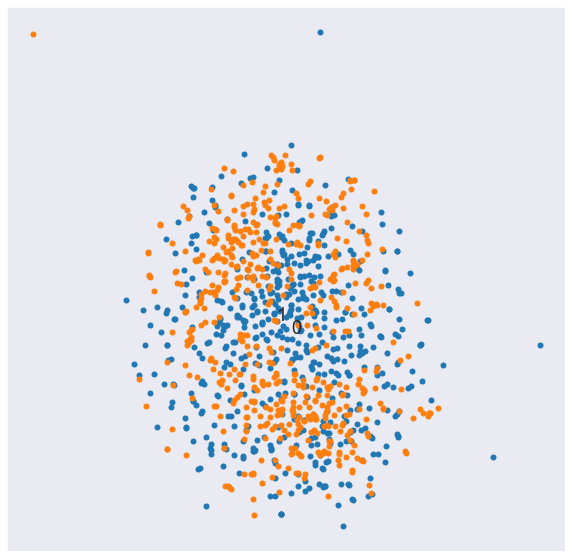

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10)) 

plt.xticks([],[])
plt.yticks([],[])
for target in np.unique(y):
    selection = y == target
    X1, X2 = Tx[selection,0], Tx[selection,1]
    c1, c2 = np.median(X1), np.median(X2)
    plt.plot(X1, X2, 'o', ms=5)
    plt.text(c1, c2, target, fontsize=18)

### Machine learning classifier
Classifier saved in pkl file

In [11]:
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# cross-validator : Stratified ShuffleSplit 
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42)

# Functions to be used in the pipeline
skb = SelectKBest(f_classif)

# avoid display warning in case ML does not reach convergence within maxiter
from warnings import filterwarnings
filterwarnings('ignore')


# import Multi-layer Perceptron classifier
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ("MLP", clf)
])

# parameters to tune 
param_grid = {
    "MLP__solver":['lbfgs','adam','sgd'],
    "MLP__alpha":[1e-5],
    "MLP__hidden_layer_sizes":[(30, 30)],
    "MLP__random_state":[1],
    "MLP__max_iter":[500],
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss)

# training classifier
print (" > training classifier:")
t0 = time()
grid.fit(features_train, labels_train)
print ("training time: ", round(time()-t0, 3), "s")

# best classifier using the cross-validator and the Stratified Shuffle Split 
clf = grid.best_estimator_

# predicition with the classifier
t0 = time()
pred = clf.predict(features_test)
print ("testing time: ", round(time()-t0, 3), "s")

# evaluation metrics
print ("\n > metrics evaluation:")
print (classification_report(labels_test, pred))

# print grid parameters
print ("\n > Best parameters:")
print (grid.best_params_)

# dump classifier in a pickle file
print ("\n > Classifier dumped")
with open("deceptive_classifier.pkl", 'wb') as fid:
    pk.dump(clf, fid)

 > training classifier:
training time:  302.48 s
testing time:  0.047 s

 > metrics evaluation:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       233
           1       0.84      0.87      0.85       247

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480


 > Best parameters:
{'MLP__alpha': 1e-05, 'MLP__hidden_layer_sizes': (30, 30), 'MLP__max_iter': 500, 'MLP__random_state': 1, 'MLP__solver': 'adam'}

 > Classifier dumped


### Loading classifier

In [12]:
# Load classifier
with open("deceptive_classifier.pkl", 'rb') as fid:
    clf_trained = pk.load(fid)

### Text to identify deceptive or truthful

In [13]:
text_to_predict = "This hotel is one superior hotel"

### Results

In [14]:
prepared_text = parseOutText(text_to_predict)
feat_array = vectorizer.transform([prepared_text]).toarray()

# Display predictions
result = clf_trained.predict(feat_array)[0]
if result == 1:
    print('Deceptive')
else:
    print('Truthful')

Deceptive
